# Student exam performance classification using sklearn Decision tree

In [38]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
#from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, average_precision_score, precision_recall_fscore_support, classification_report
from sklearn import tree

## Preprocessing 

In [2]:
#Read data into dataframe

df1 = pd.read_csv('StudentsPerformance.csv')
df1.rename(columns={'parental level of education': 'parent educ', 'test preparation course': 'prep course'}, inplace=True)
df1.head()

,gender,race/ethnicity,parent educ,lunch,prep course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
df2 = pd.read_csv('StudentsPerformance.csv')

#Convert the three scores into one total average score:

avg_score = []
for row in df2.itertuples():
    score = (row._6 + row._7 + row._8) / 3
    score = np.round(score, 3)
    avg_score.append(score)

del df2['math score']
del df2['reading score']
del df2['writing score']
df2['score'] = avg_score

df2.rename(columns={'parental level of education': 'parent edu', 'test preparation course': 'prep course'}, inplace=True)
df2.head()


,gender,race/ethnicity,parent edu,lunch,prep course,score
0,female,group B,bachelor's degree,standard,none,72.667
1,female,group C,some college,standard,completed,82.333
2,female,group B,master's degree,standard,none,92.667
3,male,group A,associate's degree,free/reduced,none,49.333
4,male,group C,some college,standard,none,76.333


In [4]:
# Find mean
avg_score = []
for row in df2.itertuples():
    sc = (row.score)
    avg_score.append(sc)
    
def mean_value(lst): 
    return sum(lst) / len(lst) 

mean_score = np.round(mean_value(avg_score),3)
print('The mean score for all 1000 students is ' + str(mean_score) + '\n\n')

# or just
df2.describe()

The mean score for all 1000 students is 67.771




,score
count,1000.000000
mean,67.770658
std,14.257324
min,9.000000
25%,58.333000
50%,68.333000
75%,77.667000
max,100.000000


### Encoding of variables

As sklearn's decisiontreeclassifier implementation does not handle categorical values, our categorical columns must be one-hot encoded. LabelEncoding might work, but the decision tree will treat the values as continuous numerical. First will try one-hot encoding the categorical values.

- Gender: Male or female (2 categories)

- Race/ethnicity: Groups A, B, C, D, E (5 categories)

- parental education: some high school, high school, some college, associate's degree, bachelor's degree, master's degree (6 categories), this is a ordinal category (eg. low, medium, high) and should be looked into further 

- lunch: standard or free/reduced (2 categories)

- preparation course: none, completed (2 categories)


Variables with two categories will be transformed into 1/0 binary values, to avoid unnecessary high dimensionality. This is done simply by one hote encoding, and deleting the extra column.

The ones that will be one-hot encoded are race/ethnicity and parental education level, they will have extra columns:

In [5]:
df3 = df2

In [6]:
# Pandas approach:
enc_edu = pd.get_dummies(df3['parent edu'], prefix = 'parent')
enc_race = pd.get_dummies(df3['race/ethnicity'], prefix = 'race')
enc_gend = pd.get_dummies(df3['gender'], prefix = 'gender')
enc_lunch = pd.get_dummies(df3['lunch'], prefix = 'lunch')
enc_course = pd.get_dummies(df3['prep course'], prefix = 'course')

#For the variables with two categories, we do not want another column as it can just be made binary.
#Concatenate the dummies, and remove the default columns. Furthermore, we remove the extras and rename the 2-dimensioned columns so it is binary

#e.g. gender: 1-female, 0-male,  lunch: 1-standard, 0-free/reduced,  prep course: 1-completed, 0-none
#for the others we will keep all as new variables. 


df3 = pd.concat((df3, enc_edu, enc_race, enc_gend, enc_lunch, enc_course), axis=1)

#drop the original columns, no longer need them,
df3 = df3.drop(['gender', 'race/ethnicity', 'parent edu', 'lunch', 'prep course'], axis=1)

#drop the extra variables added due to dummy creation, for the binary variables, and rename
df3 = df3.drop(['gender_male', 'lunch_free/reduced', 'course_none'], axis=1)
df3.rename(columns={'gender_female': 'gender', 'lunch_standard': 'standard lunch', 'course_completed': 'completed course'}, inplace=True)
df3.rename(columns={'race_group A': 'race A', 'race_group B': 'race B', 'race_group C': 'race C', 'race_group D': 'race D', 'race_group E': 'race E'}, inplace=True)

#Thus, we end up with the one-hot encoded feature variables in the dataset: 

df3.head()

,score,parent_associate's degree,parent_bachelor's degree,parent_high school,parent_master's degree,parent_some college,parent_some high school,race A,race B,race C,race D,race E,gender,standard lunch,completed course
0,72.667,0,1,0,0,0,0,0,1,0,0,0,1,1,0
1,82.333,0,0,0,0,1,0,0,0,1,0,0,1,1,1
2,92.667,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,49.333,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,76.333,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [7]:
df2.head()

,gender,race/ethnicity,parent edu,lunch,prep course,score
0,female,group B,bachelor's degree,standard,none,72.667
1,female,group C,some college,standard,completed,82.333
2,female,group B,master's degree,standard,none,92.667
3,male,group A,associate's degree,free/reduced,none,49.333
4,male,group C,some college,standard,none,76.333


### Target variable encoding

Finally, we need to fix the target column, that is score. Using float values, as they are standing now, makes this a regression type of problem. Our problem proposal was predicting whether a student performs below or above average, based on the input variables. Thus, have to change the score column and classify each score as below or above average, to transform the problem to a binary classification problem. 

In [8]:
#Mean is already found to be 67.771, all below are noted below avg and other above avg

mean = 67.771

scoreclass = []
for row in df3.itertuples():
    if(row.score >= mean):
        scoreclass.append('above avg')
    else:
        scoreclass.append('below avg')
    

df3['score_1'] = scoreclass #Add list as a column in dataframe

#One hot encoding
enc_target = pd.get_dummies(df3['score_1'], prefix = 'course')
df3 = pd.concat((df3, enc_target), axis=1)
df3 = df3.drop(['score_1', 'score', 'course_below avg'], axis=1)
df3.rename(columns={'course_above avg': 'above avg score'}, inplace=True)



df3.head()


,parent_associate's degree,parent_bachelor's degree,parent_high school,parent_master's degree,parent_some college,parent_some high school,race A,race B,race C,race D,race E,gender,standard lunch,completed course,above avg score
0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1
1,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1
2,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1


In [9]:
#Above avg score, 1 is yes 0 is no. gender, 1 is female, 0 s male, standard lunch 1 is standard, 0 is free/reduced, completed course, 0 is no 1 is yes

df2.head()

,gender,race/ethnicity,parent edu,lunch,prep course,score
0,female,group B,bachelor's degree,standard,none,72.667
1,female,group C,some college,standard,completed,82.333
2,female,group B,master's degree,standard,none,92.667
3,male,group A,associate's degree,free/reduced,none,49.333
4,male,group C,some college,standard,none,76.333


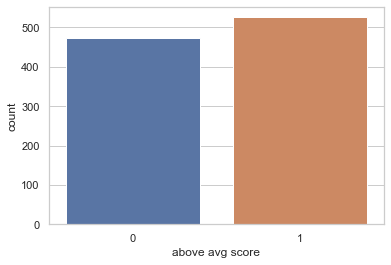

In [10]:

import seaborn as sns
sns.set(style='whitegrid')

sns.countplot(df3['above avg score'])


plt.show()

#as expected. See also stats notebook

# Model training

First using train-test split

In [37]:
feature_cols = ["parent_associate's degree", "parent_bachelor's degree", "parent_high school", "parent_master's degree", "parent_some college", "parent_some high school", "race A", "race B", "race C", "race D", "race E", "gender", "standard lunch", "completed course"]

X = df3[feature_cols] #Features
y = df3['above avg score'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

clf1 = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth=3)

clf1 = clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred))

#Sensitivity Specificity?

print(clf1.score(X_test, y_test))
print(clf1.score(X_train, y_train))



Accuracy:  0.7
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        38
           1       0.74      0.81      0.77        62

    accuracy                           0.70       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.69      0.70      0.69       100

[[20 18]
 [12 50]]
0.7
0.6433333333333333


Try with cross-validation instead of simple split. Utilizing all of our data might lead to better performance, and leave less to chance. We will use k-fold cross validation here. (might also check out stratifiedkfold?)